In [1]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
import datetime, os

In [2]:
%run 'yolov3_tf2.ipynb'

In [3]:
%run 'utils.ipynb'

In [4]:
dataset = './data/audi_train.tfrecord' #'path to dataset'
val_dataset = './data/audi_val.tfrecord' # 'path to validation dataset'
weights = './checkpoints/yolov3.tf' #'path to weights file'
classes = './data/classes.txt' #'path to classes file'
mode = 'fit' #['fit', 'eager_fit', 'eager_tf']
             #'fit: model.fit, '
             #'eager_fit: model.fit(run_eagerly=True), '
             #'eager_tf: custom GradientTape'
transfer = 'darknet'
             #['none', 'darknet', 'no_output', 'frozen', 'fine_tune'],
             #'none: Training from scratch, '
             #'darknet: Transfer darknet, '
             #'no_output: Transfer all but output, '
             #'frozen: Transfer and freeze all, '
             #'fine_tune: Transfer all and freeze darknet only'
size = 416 #'image size'
epochs = 50 #'number of epochs'
batch_size = 16 #'batch size'
learning_rate = 1e-3 #'learning rate'
num_classes = 14 #'number of classes in the model'
weights_num_classes = 80 #'specify num class for `weights` file if different, '
                         #'useful in transfer learning with different number of classes'


def train_model():  
    model = YoloV3(size, training=True, classes=num_classes)
    anchors = yolo_anchors
    anchor_masks = yolo_anchor_masks

    train_dataset = load_fake_dataset()
    if dataset:
        train_dataset = load_tfrecord_dataset(dataset, classes, size)
    train_dataset = train_dataset.shuffle(buffer_size=512)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.map(lambda x, y: (
        transform_images(x, size),
        transform_targets(y, anchors, anchor_masks, size)))
    train_dataset = train_dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)
    
    v_dataset = load_fake_dataset()
    if val_dataset:
        v_dataset = load_tfrecord_dataset(val_dataset, classes, size)
    v_dataset = v_dataset.batch(batch_size)
    v_dataset = v_dataset.map(lambda x, y: (
        transform_images(x, size),
        transform_targets(y, anchors, anchor_masks, size)))
    
    # Configure the model for transfer learning
    if transfer == 'none':
        pass  # Nothing to do
    elif transfer in ['darknet', 'no_output']:
        # Darknet transfer is a special case that works
        # with incompatible number of classes

        # reset top layers
        model_pretrained = YoloV3(
            size, training=True, classes=weights_num_classes or num_classes)
        model_pretrained.load_weights(weights)

        if transfer == 'darknet':
            model.get_layer('yolo_darknet').set_weights(
                model_pretrained.get_layer('yolo_darknet').get_weights())
            freeze_all(model.get_layer('yolo_darknet'))

        elif transfer == 'no_output':
            for l in model.layers:
                if not l.name.startswith('yolo_output'):
                    l.set_weights(model_pretrained.get_layer(
                        l.name).get_weights())
                    freeze_all(l)

    else:
        # All other transfer require matching classes
        model.load_weights(weights)
        if transfer == 'fine_tune':
            # freeze darknet and fine tune other layers
            darknet = model.get_layer('yolo_darknet')
            freeze_all(darknet)
        elif transfer == 'frozen':
            # freeze everything
            freeze_all(model)

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = [YoloLoss(anchors[mask], classes=num_classes)
            for mask in anchor_masks]

    if mode == 'eager_tf':
        # Eager mode is great for debugging
        # Non eager graph mode is recommended for real training
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

        for epoch in range(1, epochs + 1):
            for batch, (images, labels) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    outputs = model(images, training=True)
                    regularization_loss = tf.reduce_sum(model.losses)
                    pred_loss = []
                    for output, label, loss_fn in zip(outputs, labels, loss):
                        pred_loss.append(loss_fn(label, output))
                    total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                grads = tape.gradient(total_loss, model.trainable_variables)
                optimizer.apply_gradients(
                    zip(grads, model.trainable_variables))

                logging.info("{}_train_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_loss.update_state(total_loss)

            for batch, (images, labels) in enumerate(v_dataset):
                outputs = model(images)
                regularization_loss = tf.reduce_sum(model.losses)
                pred_loss = []
                for output, label, loss_fn in zip(outputs, labels, loss):
                    pred_loss.append(loss_fn(label, output))
                total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                logging.info("{}_val_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_val_loss.update_state(total_loss)

            logging.info("{}, train: {}, val: {}".format(
                epoch,
                avg_loss.result().numpy(),
                avg_val_loss.result().numpy()))

            avg_loss.reset_states()
            avg_val_loss.reset_states()
            model.save_weights(
                'checkpoints/yolov3_train_{}.tf'.format(epoch))
    else:
        model.compile(optimizer=optimizer, loss=loss,
                      run_eagerly=(mode == 'eager_fit'))

        callbacks = [
            ReduceLROnPlateau(monitor='loss',verbose=1),
            EarlyStopping(patience=3,monitor='loss', verbose=1),
            ModelCheckpoint('checkpoints/yolov3_train_{epoch}.tf',
                            verbose=1, save_weights_only=True),
            TensorBoard(log_dir='logs')
        ]

        history = model.fit(train_dataset,
                            epochs=epochs,
                            callbacks=callbacks,
                            validation_data=v_dataset)

In [5]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

In [6]:
train_model()

Epoch 1/50
    515/Unknown - 7070s 14s/step - loss: 238.1716 - yolo_output_0_loss: 12.3531 - yolo_output_1_loss: 41.7612 - yolo_output_2_loss: 173.0352
Epoch 00001: saving model to checkpoints/yolov3_train_1.tf
515/515 [==============================] - 8315s 16s/step - loss: 238.1722 - yolo_output_0_loss: 12.3531 - yolo_output_1_loss: 41.7612 - yolo_output_2_loss: 173.0352 - val_loss: 33.2720 - val_yolo_output_0_loss: 1.9814 - val_yolo_output_1_loss: 6.9337 - val_yolo_output_2_loss: 13.3413
Epoch 2/50
514/515 [============================>.] - ETA: 13s - loss: 26.3463 - yolo_output_0_loss: 1.4225 - yolo_output_1_loss: 5.8036 - yolo_output_2_loss: 8.1304
Epoch 00002: saving model to checkpoints/yolov3_train_2.tf
515/515 [==============================] - 8288s 16s/step - loss: 26.3359 - yolo_output_0_loss: 1.4247 - yolo_output_1_loss: 5.8019 - yolo_output_2_loss: 8.1195 - val_loss: 23.4288 - val_yolo_output_0_loss: 1.4330 - val_yolo_output_1_loss: 5.3432 - val_yolo_output_2_loss: 5.692

514/515 [============================>.] - ETA: 14s - loss: 11.9322 - yolo_output_0_loss: 0.3526 - yolo_output_1_loss: 0.8577 - yolo_output_2_loss: 0.5530
Epoch 00033: saving model to checkpoints/yolov3_train_33.tf
515/515 [==============================] - 8596s 17s/step - loss: 11.9402 - yolo_output_0_loss: 0.3549 - yolo_output_1_loss: 0.8644 - yolo_output_2_loss: 0.5519 - val_loss: 24.9124 - val_yolo_output_0_loss: 1.4656 - val_yolo_output_1_loss: 7.4379 - val_yolo_output_2_loss: 5.8525
Epoch 34/50
514/515 [============================>.] - ETA: 13s - loss: 11.9633 - yolo_output_0_loss: 0.3438 - yolo_output_1_loss: 0.8991 - yolo_output_2_loss: 0.5558
Epoch 00034: saving model to checkpoints/yolov3_train_34.tf
515/515 [==============================] - 8158s 16s/step - loss: 11.9604 - yolo_output_0_loss: 0.3433 - yolo_output_1_loss: 0.8979 - yolo_output_2_loss: 0.5547 - val_loss: 24.6326 - val_yolo_output_0_loss: 1.4358 - val_yolo_output_1_loss: 7.6299 - val_yolo_output_2_loss: 5.447

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
lossDf = pd.read_csv('./data/YOLO_Loss.csv')
lossDf.head()

,epoch,loss,yolo_output_0_loss,yolo_output_1_loss,yolo_output_2_loss,val_loss,val_yolo_output_0_loss,val_yolo_output_1_loss,val_yolo_output_2_loss
0,1,238.1722,12.3531,41.7612,173.0352,33.2720,1.9814,6.9337,13.3413
1,2,26.3359,1.4247,5.8019,8.1195,23.4288,1.4330,5.3432,5.6927
2,3,21.7387,1.1585,4.6940,4.9596,21.6229,1.1794,5.0383,4.5144
3,4,19.7819,0.9793,4.0094,3.9408,20.4556,1.1671,4.6268,3.8507
4,5,18.5161,0.8645,3.5368,3.3441,20.3497,1.2065,4.9364,3.4781


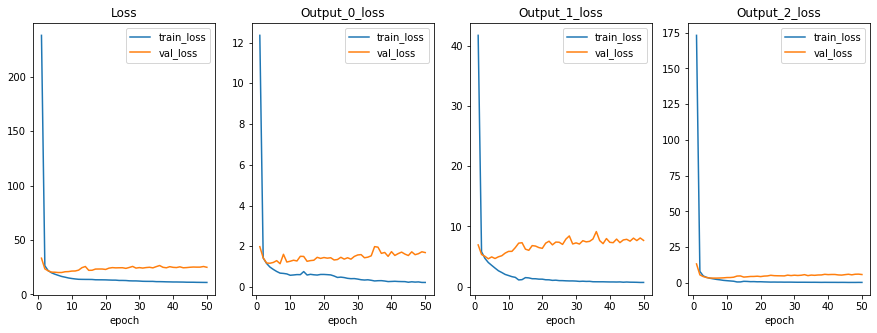

In [41]:
x = lossDf.epoch
fig, ax = plt.subplots(nrows=1,ncols = 4,figsize=(15,5))
l1,l2 = ax[0].plot(x, lossDf[['loss','val_loss']])
_ = ax[0].set_xlabel('epoch')
_ = ax[0].set_title('Loss')
_ = ax[0].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[1].plot(x, lossDf[['yolo_output_0_loss','val_yolo_output_0_loss']])
_ = ax[1].set_xlabel('epoch')
_ = ax[1].set_title('Output_0_loss')
_ = ax[1].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[2].plot(x, lossDf[['yolo_output_1_loss','val_yolo_output_1_loss']])
_ = ax[2].set_xlabel('epoch')
_ = ax[2].set_title('Output_1_loss')
_ = ax[2].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[3].plot(x, lossDf[['yolo_output_2_loss','val_yolo_output_2_loss']])
_ = ax[3].set_xlabel('epoch')
_ = ax[3].set_title('Output_2_loss')
_ = ax[3].legend([l1,l2],['train_loss','val_loss'])